In [1]:
import pandas as pd
from skmap.catalog import DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
from pathlib import Path

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

## generate the paths
years = [2000,2004,2008,2012,2016,2020,2022]


# Overlay data

In [2]:
# fn = []
# for iy in range(1,len(years)):
#     start = years[iy-1]
#     end = years[iy]
#     fne = [f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_m_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20241216.tif',
#            f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_p025_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20241216.tif',
#            f'http://192.168.1.30:8333/tmp-eumap-ai4sh/v8/oc_iso.10694.1995.kg.m3_p975_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20241216.tif']
#     fn.extend(fne)

# for ii in fn:
#     print(ii.replace('http://192.168.1.30:8333/','{base_path}/'))

# base_path = [f'http://192.168.49.{gaia_id}:8333' for gaia_id in range(30,47)]
# GDAL_OPTS = {'GDAL_HTTP_VERSION': '1.0', 'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif'}
# max_ram_mb = 500000
# n_threads = 96

# gsheet_key = '/home/xuemeng/work_xuemeng/gaia-319808-913d36b5fca4.json'
# gsheet_url = 'https://docs.google.com/spreadsheets/d/1lNTpzdHBG5dirYj46iBDRJMk_YAV0Um2ovBc8v3dR9w/edit?gid=78425683#gid=78425683'
# gsheet = GoogleSheet(gsheet_key, gsheet_url, verbose=False)

# catalog = DataCatalog.create_catalog(catalog_def=gsheet.tmp_eu_soc, years=years, base_path=base_path)

# df = gpd.read_file(f'/home/xuemeng/work_xuemeng/soc/visualizaiton/plot_time.series/plot_time.series_points.gpkg')
# df = df.to_crs(epsg=3035)

# ttprint('start overlay')
# space_overlay = SpaceOverlay(
#         points=df, 
#         catalog=catalog,
#         # raster_tiles='ard2_final_status.gpkg',
#         verbose=True,
#         n_threads=n_threads)
#         # tile_id_col='TILE')
# ttprint('finish')

# ovelayed_data = space_overlay.run(gdal_opts=GDAL_OPTS, max_ram_mb=max_ram_mb, out_file_name="ovelayed_year.pq")

# icol = []
# iname = []
# for a in ovelayed_data.columns:
#     if len(a)>10:
#         icol.append(a)
#         im = a.split('_')[2] + '_' + a.split('_')[5][0:4] + '.' + a.split('_')[6][0:4]
#         iname.append(im)
        
# name_map = dict(zip(icol, iname))
# ovelayed_data = ovelayed_data.rename(columns = name_map)

# ovelayed_data.to_csv('/home/xuemeng/work_xuemeng/soc/visualizaiton/plot_time.series/plot_time.series_ocd.csv',index=False)

# Plot with overlaid data

In [3]:
temp = pd.read_csv('/home/xuemeng/work_xuemeng/soc/visualizaiton/plot_time.series/plot_time.series_ocd.csv',low_memory=False)
time = [2002, 2006, 2010, 2014, 2018, 2021]
time_label = ['2000-2004','2004-2008','2008-2012','2012-2016','2016-2020','2020-2022']

ml = ['m_2000.2004',
 'm_2004.2008',
 'm_2008.2012',
 'm_2012.2016',
 'm_2016.2020',
 'm_2020.2022']

p975l = [ii.replace('m_','p975_') for ii in ml]
p025l = [ii.replace('m_','p025_') for ii in ml]

temp['note'] = ['Cropland','Woodland']

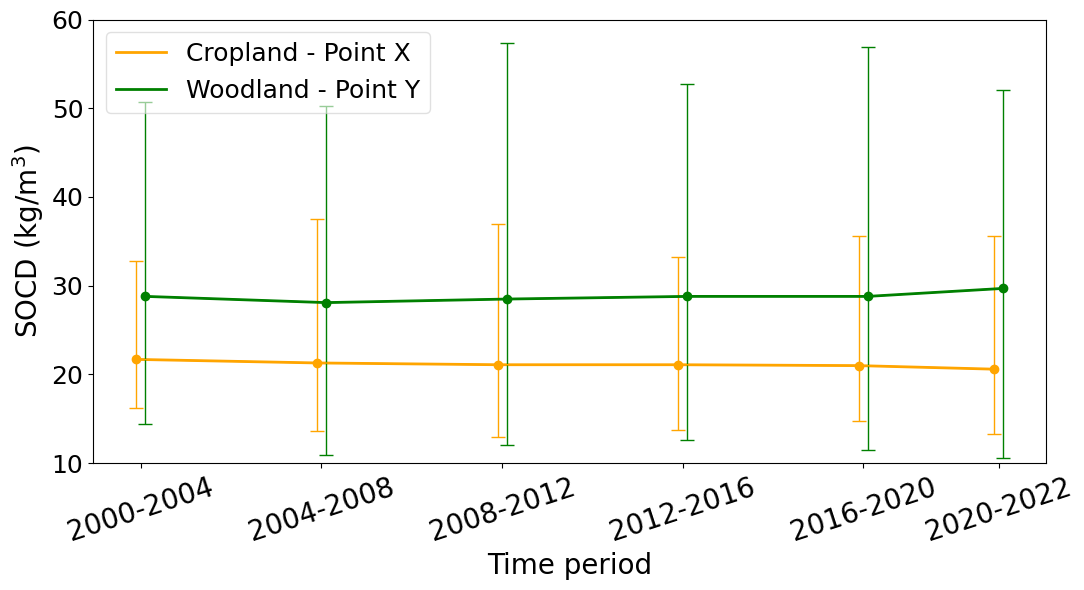

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 6))

# Offset values for time to space the plots slightly apart
offsets = [-0.1, 0.1]  # Adjust these offsets to space the error bars

# Loop through the two sets of data and plot them on the same axes with linked error bars
for idx, ii in enumerate([0, 1]):
    mean_values = temp.iloc[ii][ml] / 10
    upper_bounds = (temp.iloc[ii][p975l] / 10).values.tolist()
    lower_bounds = (temp.iloc[ii][p025l] / 10).values.tolist()
    error = [mean_values - lower_bounds, upper_bounds - mean_values]  # Calculate the error bars

    label = temp.iloc[ii]['note']
    code = temp.iloc[ii]['label']
    
    # Set colors based on label
    if label == 'Woodland':
        color = 'green'
    elif label == 'Cropland':
        color = 'orange'
    else:
        color = 'blue'  # Default color for other labels

    # Plot mean values with lines linking the points and error bars
    ax.plot([t + offsets[idx] for t in time], mean_values, label=f'{label} - Point {code}', color=color, linewidth=2)
    ax.errorbar(
        [t + offsets[idx] for t in time], mean_values, yerr=error, 
        color=color, fmt='o', capsize=5, elinewidth=1, linestyle='-', linewidth=1
    )

# Customize x-ticks and labels
ax.set_xticks(time)
ax.set_xticklabels(time_label, fontsize=20, rotation=18)
ax.set_xlabel('Time period', fontsize=20)

# Customize y-ticks and labels
yticks = ax.get_yticks().astype(int)  # Round y-ticks to integers
ax.set_yticks(yticks)
ax.set_ylim([10,60])
ax.set_yticklabels(yticks, fontsize=18)
# plt.title('Time series of SOCD and 95% PI', fontsize=20)

# Add labels and title
ax.set_ylabel('SOCD (kg/m$^3$)', fontsize=20)
ax.legend(fontsize=18, loc='upper left', framealpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as an SVG file
plt.savefig("/home/xuemeng/work_xuemeng/soc/visualizaiton/plot_time.series/plot_time.series.svg", format='svg')

# Show the plot
plt.show()

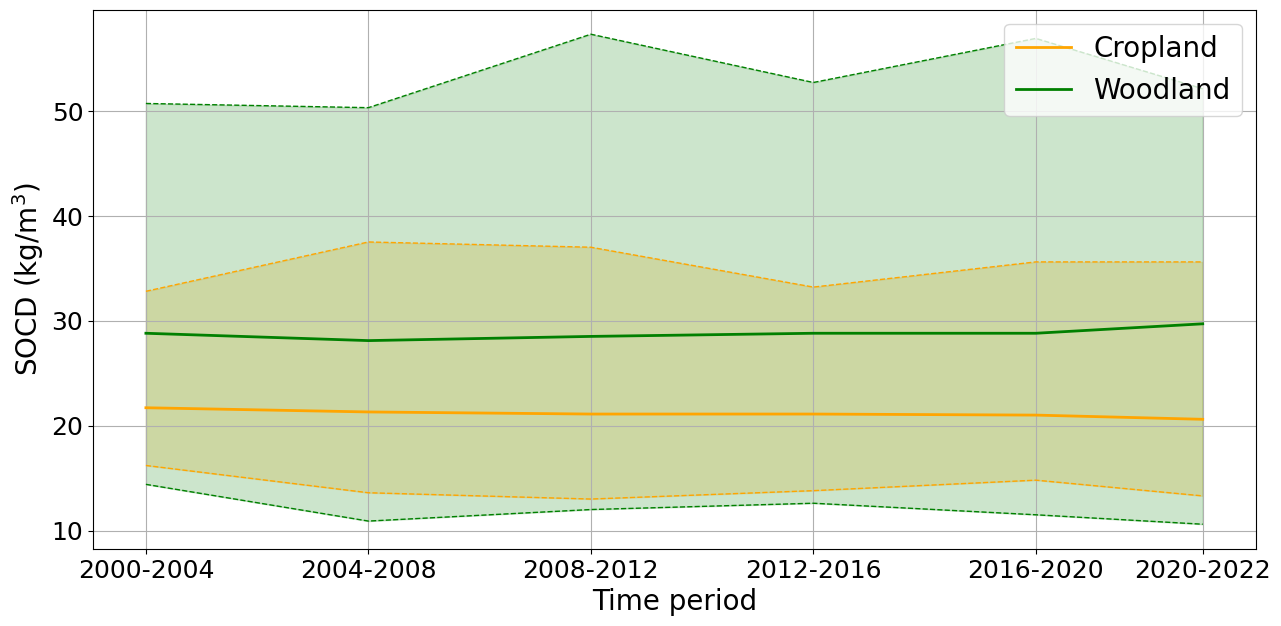

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the columns to numeric, coercing any errors
temp[ml] = temp[ml].apply(pd.to_numeric, errors='coerce')
temp[p975l] = temp[p975l].apply(pd.to_numeric, errors='coerce')
temp[p025l] = temp[p025l].apply(pd.to_numeric, errors='coerce')

# Create the plot
plt.figure(figsize=(15, 7))

# Loop over selected rows
for ii in [0,1]:
    mean_values = temp.iloc[ii][ml] / 10
    upper_bounds = (temp.iloc[ii][p975l] / 10).values.tolist()
    lower_bounds = (temp.iloc[ii][p025l] / 10).values.tolist()

    label = temp.iloc[ii]['note']
    if label == 'Woodland':
        color = 'green'
    elif label == 'Cropland':
        color = 'orange'
    else:
        color = 'blue'  # Default color if the label is something else

    plt.plot(time, mean_values, label=label, color=color, linewidth=2)
    plt.fill_between(time, lower_bounds, upper_bounds, color=color, alpha=0.2)
    plt.plot(time, upper_bounds, '--', color=color, linewidth=1)
    plt.plot(time, lower_bounds, '--', color=color, linewidth=1)
    

# Plot settings
plt.xticks(time, time_label, fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time period', fontsize=20)
plt.ylabel('SOCD (kg/m$^3$)', fontsize=20)
plt.grid(True)

# Adjusting the legend
plt.legend(fontsize=20, loc='upper right', frameon=True)
# plt.savefig("/home/opengeohub/xuemeng/work_xuemeng/soc/visualizaiton/plot_time.series/plot_time.series.svg", format='svg')
plt.show()